# Network design problem (NDP) with with graph neural networks (GNNs)

## Introduction

The aim of this project is to explore how graph neural networks (GNNs) can aid in solving Network Design Problems (NDPs). The NDP is a combinatorial optimization problem that involves finding the optimal (topological) design of a network (e.g., road network, telecommunication network) to minimize some objective function (e.g., total travel cost, total latency). In this case, we will focus on the road network design problem, where the goal is to find the optimal link capacities to minimize the total travel time on the network. In other words, given a certain budget for capacity expansion, the objective is to allocate the budget to a selection of roads optimally to minimize (in this case) the total travel time.

NDPs are generally bi-level programming problems where the upper level represents the network design decisions (e.g., link capacities) and the lower level represents the user equilibrium traffic assignment problem. The user equilibrium traffic assignment problem is a non-linear optimization problem that assigns traffic flows to the network based on the link costs (e.g., travel time) and the user behavior (e.g., route choice). The NDP is challenging due to the non-linear interactions between the network design and the traffic assignment and different objective functions of the upper level and the lower level problems, which makes it difficult to solve using traditional optimization methods, particularly for large-scale networks.

One common solution is to break the problem into the upper level and the lower level and solve them iteratively. We can use metaheuristic algorithms like Genetic Algorithms (GAs) for this approach. However, this approach can be computationally expensive too and may not scale well to large networks since we need repeated traffic assignment simulations for each design iteration.

This is where GNNs come into play. GNNs can learn the underlying patterns and relationships in the network data and can be used to predict link flows based on the network structure and demand distribution. By training a GNN to predict link flows, we can use the predicted flows to find good solutions for the NDP without the need for repeated traffic assignment simulations. This can significantly reduce the computational cost and make the solution process more scalable. This is essentially using the GNN as a surrogate model for the traffic assignment model, which requires solving an optimization problem. The trained GNN can predict link flows for different network designs, and we can use these predicted flows to evaluate the network performance and optimize the link capacities using metaheuristics like GAs. But when we use GNNs for the NDP, we need to be careful about the accuracy of the predictions since the quality of the solutions depends on the accuracy of the predicted link flows.

During the lecture on Friday, we will cover the fundamentals of NDPs and GNNs and how they can be combined to solve the NDP efficiently, and this notebook should give you a head start by demonstrating a simple example. But for in-dept information, you can consult the following article (for theory), github repository (for code), and figshare repository (for datasets):


- Article: [A hybrid deep-learning-metaheuristic framework for bi-level network design problems](https://doi.org/10.1016/j.eswa.2023.122814)
- Code: [GitHub Repository: HDLMF_GIN-GA](https://github.com/bahmanmdd/HDLMF_GIN-GA)
- Dataset: [Dataset repository](https://figshare.com/articles/dataset/_b_Equilibrium-Traffic-Networks_b_/27889251/3)


The purpose of this notebook is to demonstrate how to train a GNN to predict link flows based on network structure and demand distribution, which means the GNN inferences will replace solving the lower level optimization problem. We will use the Sioux Falls network dataset, which is a small benchmark network with 24 nodes and 76 edges. The dataset contains attributed graphs where the node attributes represent the demand distribution, and the edge attributes represent the link properties. We will train a GNN to predict link flows for different demand profiles. Note that the edge labels (link flows) are obtained by solving the traffic assignment problem (which is a non-linear constraint optimization problem) corresponding to the problem instance with each demand profile and network characteristics. We generate multiple instances of the traffic assignment problem by perturbing demand and link properties and solve each one with a specialized algorithm to obtain the ground truth labels. The goal is to train the GNN to predict these link flows accurately and to be a surrogate model for the traffic assignment model, which can be computationally expensive for large networks (note that this is only the lower level problem of the NDP).

## Summary of the training process

In the following blocks, we have wrapped everything in functions and classes to make it easier to reuse and test. The code is organized as follows:
1. Dataset Loading: This function loads the dataset from a pickle file.
2. Graph Neural Network (GNN) Model: This class defines a GNN for edge regression using the GCNConv layers from PyTorch Geometric.
3. Training Loop: This function trains the GNN model using the provided training and validation DataLoaders.
4. Evaluation Function: This function evaluates the GNN model on a given dataset (validation or test).
5. Visualization Function: This function plots the MSE loss and MAPE for both training and validation sets over epochs.

First let's import the necessary libraries and modules.

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
import pickle
import numpy as np
import matplotlib.pyplot as plt


### Dataset Loading
This function loads the dataset from a pickle file. The dataset is expected to be in the format:
(train_data, test_data, val_data), where each dataset is a list of tuples containing an attributed graph and a list of edge labels (link flows). Each graph represents a network with edge attributes representing link properties and node attributes representing demand. the graph objects are PyTorch Geometric (PyG) Data objects. PyG expects graph data in the format:
- `x`: Node features.
- `edge_index`: Edge connections as a tensor.
- `edge_attr`: Edge features.
- `y`: Edge labels for regression.



In [73]:
def load_dataset(file_path='data/SiouxFalls_1k_pyg.pkl'):
    with open(file_path, "rb") as file:
        data = pickle.load(file)

    # Unpack the dataset into train, test, and validation sets
    train_data, test_data, val_data = data
    return train_data, test_data, val_data

In [74]:
# Load datasets
train_data, test_data, val_data = load_dataset()

# Select the first sample from the training dataset to check some properties
sample_data = train_data[0]
input_features = sample_data.num_node_features
edge_features_size = sample_data.edge_attr.shape[1]

# Check node feature shape
print("Node feature shape (x):", sample_data.x.shape)

# Check edge feature shape
print("Edge feature shape (edge_attr):", sample_data.edge_attr.shape)

# Check the number of nodes and the highest node index in edge_index
print("Number of nodes:", sample_data.num_nodes)
print("Max node index in edge_index:", sample_data.edge_index.max().item())

# Check for extra rows in node features
if sample_data.x.shape[0] != sample_data.num_nodes:
    print("Warning: Node features contain extra rows!")

# Check if any node is disconnected
disconnected_nodes = set(range(sample_data.num_nodes)) - set(sample_data.edge_index.flatten().tolist())
if disconnected_nodes:
    print("Warning: Disconnected nodes detected:", disconnected_nodes)
else:
    print("All nodes are connected.")

# Check for self-loops
self_loops = sample_data.edge_index[0] == sample_data.edge_index[1]
if self_loops.any():
    print(f"Warning: Self-loops detected in {self_loops.sum().item()} edges.")
else:
    print("No self-loops detected.")

# Final check for edge label shape
print("Edge label shape (y):", sample_data.y.shape)

Node feature shape (x): torch.Size([24, 24])
Edge feature shape (edge_attr): torch.Size([76, 2])
Number of nodes: 24
Max node index in edge_index: 23
All nodes are connected.
No self-loops detected.
Edge label shape (y): torch.Size([76])


In [75]:
# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


### Graph Neural Network (GNN) Model
This class defines a GNN for edge regression using the GCNConv layers from PyTorch Geometric.
The model includes:
- Two GCNConv layers for node feature propagation.
- An MLP for predicting edge-level scores using node and edge features.



In [76]:
class EdgeRegressionGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_features_size):
        super(EdgeRegressionGNN, self).__init__()

        # Define two GCNConv layers for node embeddings
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        # Define a feed-forward neural network (MLP) for edge prediction
        self.edge_predictor = nn.Sequential(
            nn.Linear(hidden_channels * 2 + edge_features_size, 64),
            nn.ReLU(),
            nn.Linear(64, out_channels)
        )

    def forward(self, data):
        # Extract node features, edge connections, and edge attributes
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Pass node features through the GCN layers with ReLU activations
        h = torch.relu(self.conv1(x, edge_index))
        h = torch.relu(self.conv2(h, edge_index))

        # Get source and target node embeddings for each edge
        row, col = edge_index
        edge_embeds = torch.cat([h[row], h[col], edge_attr], dim=1)  # Concatenate features

        # Predict edge scores using the MLP
        return self.edge_predictor(edge_embeds).squeeze()

In [77]:
# Initialize the model, loss function, and optimizer
model = EdgeRegressionGNN(in_channels=input_features, hidden_channels=64, out_channels=1, edge_features_size=edge_features_size).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


### Training Loop
This function trains the GNN model using the provided training and validation DataLoaders.
The function calculates both the MSE loss and MAPE (Mean Absolute Percentage Error) at each epoch.



In [78]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs=50):
    # Initialize lists to store loss and MAPE for each epoch
    train_losses, val_losses, train_mape, val_mape = [], [], [], []

    for epoch in range(epochs):
        # Set the model to training mode
        model.train()
        epoch_loss, epoch_mape = 0, 0

        for data in train_loader:
            # Move data to the appropriate device (CPU/GPU)
            data = data.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass and calculate loss
            predictions = model(data)
            loss = loss_fn(predictions, data.y)

            # Calculate MAPE
            mape = torch.mean(torch.abs((predictions - data.y) / data.y)) * 100

            # Backpropagation and optimizer step
            loss.backward()
            optimizer.step()

            # Accumulate epoch loss and MAPE
            epoch_loss += loss.item()
            epoch_mape += mape.item()

        # Calculate average loss and MAPE for the epoch
        train_losses.append(epoch_loss / len(train_loader))
        train_mape.append(epoch_mape / len(train_loader))

        # Evaluate on the validation set
        val_loss, val_mape_epoch = evaluate_model(model, val_loader, loss_fn)
        val_losses.append(val_loss)
        val_mape.append(val_mape_epoch)

        # Print epoch metrics
        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Train MAPE: {train_mape[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val MAPE: {val_mape[-1]:.2f}%")

    return train_losses, val_losses, train_mape, val_mape


### Evaluation Function
This function evaluates the GNN model on a given dataset (validation or test).
It calculates both the MSE loss and the MAPE (Mean Absolute Percentage Error).



In [79]:
def evaluate_model(model, dataloader, loss_fn):
    # Set the model to evaluation mode
    model.eval()
    total_loss, total_mape = 0, 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for data in dataloader:
            # Move data to the appropriate device
            data = data.to(device)

            # Perform forward pass and calculate loss
            predictions = model(data)
            loss = loss_fn(predictions, data.y)

            # Calculate MAPE
            mape = torch.mean(torch.abs((predictions - data.y) / data.y)) * 100

            # Accumulate total loss and MAPE
            total_loss += loss.item()
            total_mape += mape.item()

    # Return average loss and MAPE
    return total_loss / len(dataloader), total_mape / len(dataloader)


In [80]:
# Train the model
print("[I] Starting training...")
train_losses, val_losses, train_mape, val_mape = train_model(model, train_loader, val_loader, loss_function, optimizer, epochs=200)

[I] Starting training...
Epoch 1/200 - Train Loss: 39976445.7931, Train MAPE: 45.43%, Val Loss: 18714734.0000, Val MAPE: 35.17%
Epoch 2/200 - Train Loss: 18100001.9655, Train MAPE: 35.25%, Val Loss: 17408467.0000, Val MAPE: 33.28%
Epoch 3/200 - Train Loss: 14789435.8621, Train MAPE: 31.51%, Val Loss: 12450523.0000, Val MAPE: 28.14%
Epoch 4/200 - Train Loss: 10349129.8621, Train MAPE: 25.54%, Val Loss: 9320564.5000, Val MAPE: 22.71%
Epoch 5/200 - Train Loss: 8876618.7931, Train MAPE: 22.83%, Val Loss: 9153249.0000, Val MAPE: 21.63%
Epoch 6/200 - Train Loss: 8821707.1552, Train MAPE: 22.65%, Val Loss: 9269568.0000, Val MAPE: 21.53%
Epoch 7/200 - Train Loss: 8682177.6379, Train MAPE: 22.43%, Val Loss: 8915812.5000, Val MAPE: 21.64%
Epoch 8/200 - Train Loss: 8674412.8276, Train MAPE: 22.40%, Val Loss: 8689421.5000, Val MAPE: 22.61%
Epoch 9/200 - Train Loss: 8674046.5000, Train MAPE: 22.42%, Val Loss: 8648806.5000, Val MAPE: 21.96%
Epoch 10/200 - Train Loss: 8603655.5345, Train MAPE: 22.37%

In [81]:
# Evaluate on the test set
print("[I] Evaluating on test set...")
test_loss, test_mape = evaluate_model(model, test_loader, loss_function)
print(f"Test Loss: {test_loss:.4f}, Test MAPE: {test_mape:.2f}%")

[I] Evaluating on test set...
Test Loss: 5221188.2500, Test MAPE: 16.80%



### Visualization Function
This function plots the MSE loss and MAPE for both training and validation sets over epochs.
The plot includes:
- MSE loss over epochs.
- MAPE over epochs.



In [82]:
def plot_metrics(train_losses, val_losses, train_mape, val_mape):
    plt.figure(figsize=(16, 9))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='b')
    plt.plot(val_losses, label='Val Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('MSE Loss over Epochs')
    plt.legend()

    # Plot MAPE
    plt.subplot(1, 2, 2)
    plt.plot(train_mape, label='Train MAPE', color='g')
    plt.plot(val_mape, label='Val MAPE', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('MAPE (%)')
    plt.title('MAPE over Epochs')
    plt.legend()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

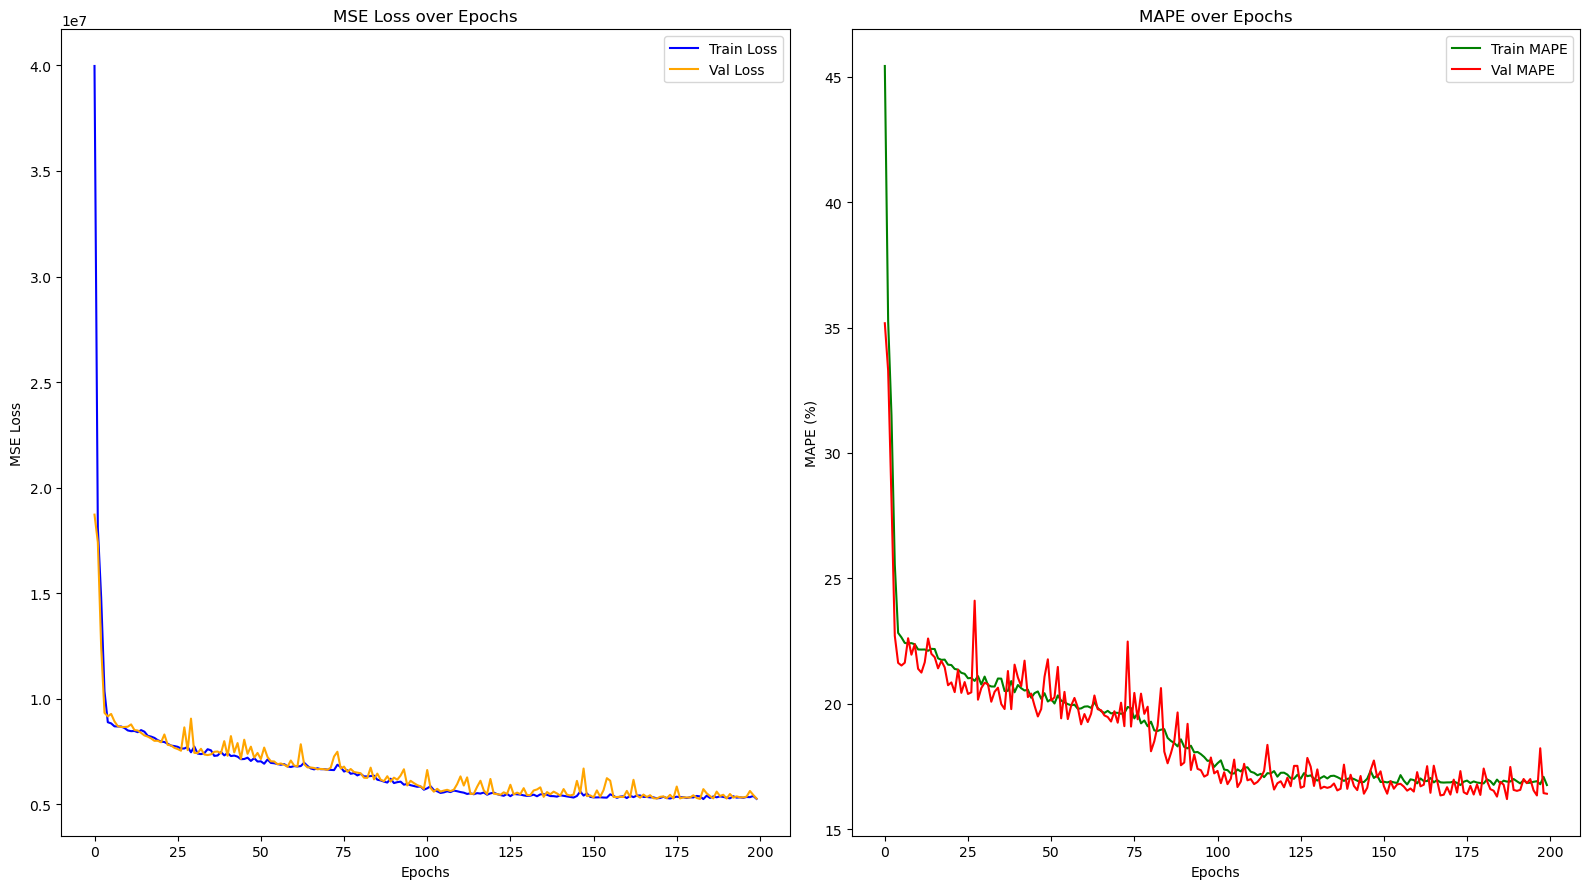

In [83]:
# Plot the metrics
plot_metrics(train_losses, val_losses, train_mape, val_mape)

## Exercise 1: Model Improvement
Now it is your turn to try to improve the model. You can also try larger datasets (available from the figshare repository mentioned earlier). Remember, for this specific application, we need accuracies above 95% and ideally higher. Here are some ideas to get you started:
- Different GNN architectures.
- Hyperparameter tuning.
- Different loss functions.
- Different optimizers, epochs and learning rates.
- Regularization techniques (dropout, L2 regularization, etc.)
- Feature augmentation (new features, fusion of existing features, centrality measures, etc.)
- Physics-informed neural networks (flow conservation constraints, etc.)
- Visualizing predictions and individual edge flow errors and penalizing solutions with asymmetric flow accuracies (biases in specific parts of the network can cause serious issues). Can you reflect on why this is important?

Good luck!

## Exercise 2: Inference with the trained model and tackling the NDP

For this exercise you need to read the paper and check the github repository mentioned earlier. You can use the trained model to predict link flows on a given network. Then, you can use the predicted link flows to find good solutions for the NDP (Network Design Problem) using a Genetic Algorithm (GA) or any other metaheuristic. The goal is to find the optimal network design (e.g., link capacities) that minimizes the total travel cost on the network. You can compare your solutions with the benchmark results to see how well you have done. Good luck!

Disclaimer: The NDP is a complex problem and may require additional knowledge and expertise to solve effectively. The lecture on Friday should help a lot but in the meantime, feel free to reach out for any questions or guidance.

## Exercise 3: Better ways of training and using GNNs for the NDP

In this exercise, you can explore better ways of training and using GNNs for the NDP. Some ideas to consider:
- Using different augmented features and graph representations.
- Using reinforcement learning (RL).
- Using GNNs for a different part of the NDP (here, we used them as surrogates for the traffic assignment model).